In [1]:
#vérification du bon fonctionnement et du lancement du sc
#import des packages nécessaires
#sc
import utils
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from pandas import DataFrame
from pyspark.mllib.stat import Statistics


In [34]:
#chargement du fichier glass.csv
nomF = "glass"
dataGlass = sc.textFile("file:/C:/spark-1.6.0-bin-hadoop2.4/"+nomF+".csv")
#séparation des colonnes
lines = dataGlass.map(lambda line: utils.toRow(line, ';'))
#ligne 1 = header -> save header
nomColInit = lines.take(1)[0]
#save nb col
nbColInit = len(nomColInit)
#sruppression du header
parts = lines.filter(lambda line: nomColInit != line) 
parts = parts.filter(lambda line: len(line) == nbColInit)
#cptage nb lignes (sans le header)   
nbLignesInit = parts.count()
#cptage erreur : nb col header != nb col de la ligne 
partsError = parts.filter(lambda line: len(line) != nbColInit)
nbErrorL = partsError.count()
#tableau résumé 
data = pd.DataFrame({'1-nom Fichier':[nomF],
                       '2-nb Col':[nbColInit],
                       '3-nb Lignes': [nbLignesInit],
                        '4-nb Lignes error': [nbErrorL]})
data

,1-nom Fichier,2-nb Col,3-nb Lignes,4-nb Lignes error
0,glass,9,214,0


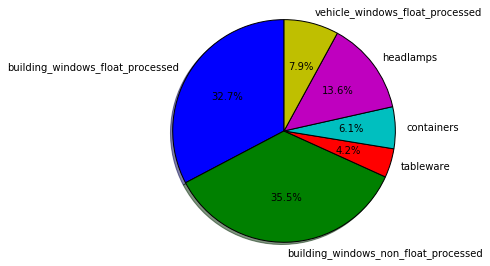

In [5]:
#La variable à prédire est le type : col=9
#nomColInit[9]

##################################################
# Répartition des classes de la variable à prédire

# traitement sur la 9ème col
typeV = parts.map(lambda line: line[9])
# map + reduce
distribType = typeV.map(lambda typeT: (typeT, 1)).reduceByKey(lambda a, b: a+b)
i = 0
name = []
data = []
while i <6:
    name = name + [distribType.collect()[i][0]]
    data = data +[int(distribType.collect()[i][1])]
    i+=1
plt.pie(data, labels=name, autopct='%1.1f%%', startangle=90, shadow=True)
plt.axis('equal')
plt.show()

In [27]:
##### En trichant #####
# Utilisation de pandas pour résumer les données + afficher la matrice de corrélation
df = pd.read_csv("file:/C:/spark-1.6.0-bin-hadoop2.4/"+nomF+".csv", sep = ";",header=0)
df.describe()
# Matrice de corrélation
# print(df.corr())

,Sodium,Magnesium,Aluminum,Silicon,Potassium,Calcium,Barium,Iron
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009
std,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439
min,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000
25%,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000
50%,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000
75%,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000
max,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000


In [37]:
# Utilisation du package mllib
# Basics Statistics
partsNum = parts.map(lambda line: line[0:8])
summary = Statistics.colStats(partsNum)
print(summary.mean())
print(summary.variance())
print(summary.numNonzeros())
Statistics.corr(partsNum, method="pearson")

[  1.34078505e+01   2.68453271e+00   1.44490654e+00   7.26509346e+01
   4.97056075e-01   8.95696262e+00   1.75046729e-01   5.70093458e-02]
[ 0.66684137  2.08054039  0.24927018  0.59992119  0.4253542   2.02536585
  0.24722699  0.0094943 ]
[ 214.  172.  214.  214.  184.  214.   38.   70.]


In [1]:
###############
# Naive Bayes #
###############

from pyspark.mllib.classification import NaiveBayes, NaiveBayesModel
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.regression import LabeledPoint
import utils_mesure
import pandas as pd

def parseLine(line):
    parts = line.split(';')
    label = float(parts[8])
    features = Vectors.dense([float(x) for x in parts[0:7]])
    return LabeledPoint(label, features)

data = sc.textFile("file:/C:/spark-1.6.0-bin-hadoop2.4/glass_svm.csv")

# suppression du header
nomColInit = data.first()
data2 = data.filter(lambda line: nomColInit != line) 
data = data2.map(parseLine)

# Echantillonnage 60% entrainement et 40% test
training, test = data.randomSplit([0.6, 0.4], seed=0)
# construction d'un modèle Bayesien sur l'échantillon d'entrainement
model = NaiveBayes.train(training, 1.0)

# Application sur l'echantillon test
predictionAndLabel = test.map(lambda p: (model.predict(p.features), p.label))

# Calcul des indicateurs du modèle
accuracy = 1.0 * predictionAndLabel.filter(lambda (x, v): x == v ).count() / test.count()
pG = 0
rG = 0
i = 1
while i < 7:
    a = utils_mesure.matriceConf(predictionAndLabel, i)
    pG = pG + utils_mesure.precision(a)
    rG = rG + utils_mesure.rappel(a)
    i += 1
pG = pG /6
rG = rG /6
fM = utils_mesure.f_mesure(rG, pG)

# Résumée des mesures du modèle
data = pd.DataFrame({'1-Méthode':["NaiveBayes"],
                    '2-Précision':[pG],
                       '3-Rappel':[rG],
                       '4-F_mesure': [fM]})
data



,1-Méthode,2-Précision,3-Rappel,4-F_mesure
0,NaiveBayes,0.355919,0.368657,1.105971


##### En cours #####


In [1]:
# Classification et regression 
# Méthodes linéaires
from pyspark.mllib.classification import SVMWithSGD, SVMModel
from pyspark.mllib.regression import LabeledPoint
nomF = "glass_svm"
# Load and parse the data
def parsePoint(line):
    values = [x for x in line.split(';')]
    return LabeledPoint(values[8], values[0:7])

data = sc.textFile("file:/C:/spark-1.6.0-bin-hadoop2.4/"+nomF+".csv")
data.first()
nomColInit = data.first()
#sruppression du header
data2 = data.filter(lambda line: nomColInit != line) 

parsedData = data2.map(parsePoint)

# Build the model
model = SVMWithSGD.train(parsedData, iterations=100)

# Evaluating the model on training data
labelsAndPreds = parsedData.map(lambda p: (p.label, model.predict(p.features)))
trainErr = labelsAndPreds.filter(lambda (v, p): v != p).count() / float(parsedData.count())
print("Training Error = " + str(trainErr))

# Save and load model
#model.save(sc, "myModelPath")
#sameModel = SVMModel.load(sc, "myModelPath")

Py4JJavaError: An error occurred while calling o55.trainSVMModelWithSGD.
: org.apache.spark.SparkException: Input validation failed.
	at org.apache.spark.mllib.regression.GeneralizedLinearAlgorithm.run(GeneralizedLinearAlgorithm.scala:251)
	at org.apache.spark.mllib.api.python.PythonMLLibAPI.trainRegressionModel(PythonMLLibAPI.scala:94)
	at org.apache.spark.mllib.api.python.PythonMLLibAPI.trainSVMModelWithSGD(PythonMLLibAPI.scala:233)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(Unknown Source)
	at java.lang.reflect.Method.invoke(Unknown Source)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:231)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:381)
	at py4j.Gateway.invoke(Gateway.java:259)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:133)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:209)
	at java.lang.Thread.run(Unknown Source)


In [71]:
from pyspark.mllib.classification import LogisticRegressionWithLBFGS, LogisticRegressionModel

model = LogisticRegressionWithLBFGS.train(parsedData, numClasses=2)


Py4JJavaError: An error occurred while calling o1353.trainLogisticRegressionModelWithLBFGS.
: org.apache.spark.SparkException: Input validation failed.
	at org.apache.spark.mllib.regression.GeneralizedLinearAlgorithm.run(GeneralizedLinearAlgorithm.scala:251)
	at org.apache.spark.mllib.api.python.PythonMLLibAPI.trainRegressionModel(PythonMLLibAPI.scala:94)
	at org.apache.spark.mllib.api.python.PythonMLLibAPI.trainLogisticRegressionModelWithLBFGS(PythonMLLibAPI.scala:293)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(Unknown Source)
	at java.lang.reflect.Method.invoke(Unknown Source)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:231)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:381)
	at py4j.Gateway.invoke(Gateway.java:259)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:133)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:209)
	at java.lang.Thread.run(Unknown Source)


In [2]:
from pyspark.mllib.classification import LogisticRegressionWithLBFGS, LogisticRegressionModel
from pyspark.mllib.regression import LabeledPoint

# Load and parse the data
def parsePoint(line):
    values = [float(x) for x in line.split(' ')]
    return LabeledPoint(values[0], values[1:])

data = sc.textFile("data/mllib/sample_svm_data.txt")
parsedData = data.map(parsePoint)

# Build the model
model = LogisticRegressionWithLBFGS.train(parsedData)

# Evaluating the model on training data
labelsAndPreds = parsedData.map(lambda p: (p.label, model.predict(p.features)))
trainErr = labelsAndPreds.filter(lambda (v, p): v != p).count() / float(parsedData.count())
print("Training Error = " + str(trainErr))

# Save and load model
model.save(sc, "myModelPath2")
sameModel = LogisticRegressionModel.load(sc, "myModelPath2")

Training Error = 0.366459627329


Py4JJavaError: An error occurred while calling o63.save.
: org.apache.hadoop.mapred.FileAlreadyExistsException: Output directory file:/C:/spark-1.6.0-bin-hadoop2.4/myModelPath2/metadata already exists
	at org.apache.hadoop.mapred.FileOutputFormat.checkOutputSpecs(FileOutputFormat.java:132)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$saveAsHadoopDataset$1.apply$mcV$sp(PairRDDFunctions.scala:1179)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$saveAsHadoopDataset$1.apply(PairRDDFunctions.scala:1156)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$saveAsHadoopDataset$1.apply(PairRDDFunctions.scala:1156)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:150)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:111)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:316)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopDataset(PairRDDFunctions.scala:1156)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$saveAsHadoopFile$4.apply$mcV$sp(PairRDDFunctions.scala:1060)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$saveAsHadoopFile$4.apply(PairRDDFunctions.scala:1026)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$saveAsHadoopFile$4.apply(PairRDDFunctions.scala:1026)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:150)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:111)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:316)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopFile(PairRDDFunctions.scala:1026)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$saveAsHadoopFile$1.apply$mcV$sp(PairRDDFunctions.scala:952)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$saveAsHadoopFile$1.apply(PairRDDFunctions.scala:952)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$saveAsHadoopFile$1.apply(PairRDDFunctions.scala:952)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:150)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:111)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:316)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopFile(PairRDDFunctions.scala:951)
	at org.apache.spark.rdd.RDD$$anonfun$saveAsTextFile$1.apply$mcV$sp(RDD.scala:1443)
	at org.apache.spark.rdd.RDD$$anonfun$saveAsTextFile$1.apply(RDD.scala:1422)
	at org.apache.spark.rdd.RDD$$anonfun$saveAsTextFile$1.apply(RDD.scala:1422)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:150)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:111)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:316)
	at org.apache.spark.rdd.RDD.saveAsTextFile(RDD.scala:1422)
	at org.apache.spark.mllib.classification.impl.GLMClassificationModel$SaveLoadV1_0$.save(GLMClassificationModel.scala:61)
	at org.apache.spark.mllib.classification.LogisticRegressionModel.save(LogisticRegression.scala:159)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(Unknown Source)
	at java.lang.reflect.Method.invoke(Unknown Source)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:231)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:381)
	at py4j.Gateway.invoke(Gateway.java:259)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:133)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:209)
	at java.lang.Thread.run(Unknown Source)


In [4]:
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel
from pyspark.mllib.util import MLUtils
model2 = DecisionTree.trainClassifier(training, numClasses=6, categoricalFeaturesInfo={},
                                     impurity='entropy', maxDepth=5, maxBins=32)

Py4JJavaError: An error occurred while calling o301.trainDecisionTreeModel.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 1 in stage 41.0 failed 1 times, most recent failure: Lost task 1.0 in stage 41.0 (TID 74, localhost): java.lang.IllegalArgumentException: EntropyAggregator given label 6.0 but requires label < numClasses (= 6).
	at org.apache.spark.mllib.tree.impurity.EntropyAggregator.update(Entropy.scala:98)
	at org.apache.spark.mllib.tree.impl.DTStatsAggregator.update(DTStatsAggregator.scala:100)
	at org.apache.spark.mllib.tree.DecisionTree$.orderedBinSeqOp(DecisionTree.scala:424)
	at org.apache.spark.mllib.tree.DecisionTree$.org$apache$spark$mllib$tree$DecisionTree$$nodeBinSeqOp$1(DecisionTree.scala:516)
	at org.apache.spark.mllib.tree.DecisionTree$$anonfun$org$apache$spark$mllib$tree$DecisionTree$$binSeqOp$1$1.apply(DecisionTree.scala:541)
	at org.apache.spark.mllib.tree.DecisionTree$$anonfun$org$apache$spark$mllib$tree$DecisionTree$$binSeqOp$1$1.apply(DecisionTree.scala:538)
	at scala.collection.immutable.Map$Map1.foreach(Map.scala:109)
	at org.apache.spark.mllib.tree.DecisionTree$.org$apache$spark$mllib$tree$DecisionTree$$binSeqOp$1(DecisionTree.scala:538)
	at org.apache.spark.mllib.tree.DecisionTree$$anonfun$6$$anonfun$apply$8.apply(DecisionTree.scala:633)
	at org.apache.spark.mllib.tree.DecisionTree$$anonfun$6$$anonfun$apply$8.apply(DecisionTree.scala:633)
	at scala.collection.Iterator$class.foreach(Iterator.scala:727)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at org.apache.spark.mllib.tree.DecisionTree$$anonfun$6.apply(DecisionTree.scala:633)
	at org.apache.spark.mllib.tree.DecisionTree$$anonfun$6.apply(DecisionTree.scala:622)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$20.apply(RDD.scala:710)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$20.apply(RDD.scala:710)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:306)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:270)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:73)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:41)
	at org.apache.spark.scheduler.Task.run(Task.scala:89)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:213)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(Unknown Source)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(Unknown Source)
	at java.lang.Thread.run(Unknown Source)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1431)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1419)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1418)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:47)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1418)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:799)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:799)
	at scala.Option.foreach(Option.scala:236)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:799)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1640)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1599)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1588)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:620)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1832)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1845)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1858)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1929)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:927)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:150)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:111)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:316)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:926)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$collectAsMap$1.apply(PairRDDFunctions.scala:741)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$collectAsMap$1.apply(PairRDDFunctions.scala:740)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:150)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:111)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:316)
	at org.apache.spark.rdd.PairRDDFunctions.collectAsMap(PairRDDFunctions.scala:740)
	at org.apache.spark.mllib.tree.DecisionTree$.findBestSplits(DecisionTree.scala:651)
	at org.apache.spark.mllib.tree.RandomForest.run(RandomForest.scala:233)
	at org.apache.spark.mllib.tree.DecisionTree.run(DecisionTree.scala:60)
	at org.apache.spark.mllib.tree.DecisionTree$.train(DecisionTree.scala:86)
	at org.apache.spark.mllib.api.python.PythonMLLibAPI.trainDecisionTreeModel(PythonMLLibAPI.scala:748)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(Unknown Source)
	at java.lang.reflect.Method.invoke(Unknown Source)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:231)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:381)
	at py4j.Gateway.invoke(Gateway.java:259)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:133)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:209)
	at java.lang.Thread.run(Unknown Source)
Caused by: java.lang.IllegalArgumentException: EntropyAggregator given label 6.0 but requires label < numClasses (= 6).
	at org.apache.spark.mllib.tree.impurity.EntropyAggregator.update(Entropy.scala:98)
	at org.apache.spark.mllib.tree.impl.DTStatsAggregator.update(DTStatsAggregator.scala:100)
	at org.apache.spark.mllib.tree.DecisionTree$.orderedBinSeqOp(DecisionTree.scala:424)
	at org.apache.spark.mllib.tree.DecisionTree$.org$apache$spark$mllib$tree$DecisionTree$$nodeBinSeqOp$1(DecisionTree.scala:516)
	at org.apache.spark.mllib.tree.DecisionTree$$anonfun$org$apache$spark$mllib$tree$DecisionTree$$binSeqOp$1$1.apply(DecisionTree.scala:541)
	at org.apache.spark.mllib.tree.DecisionTree$$anonfun$org$apache$spark$mllib$tree$DecisionTree$$binSeqOp$1$1.apply(DecisionTree.scala:538)
	at scala.collection.immutable.Map$Map1.foreach(Map.scala:109)
	at org.apache.spark.mllib.tree.DecisionTree$.org$apache$spark$mllib$tree$DecisionTree$$binSeqOp$1(DecisionTree.scala:538)
	at org.apache.spark.mllib.tree.DecisionTree$$anonfun$6$$anonfun$apply$8.apply(DecisionTree.scala:633)
	at org.apache.spark.mllib.tree.DecisionTree$$anonfun$6$$anonfun$apply$8.apply(DecisionTree.scala:633)
	at scala.collection.Iterator$class.foreach(Iterator.scala:727)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at org.apache.spark.mllib.tree.DecisionTree$$anonfun$6.apply(DecisionTree.scala:633)
	at org.apache.spark.mllib.tree.DecisionTree$$anonfun$6.apply(DecisionTree.scala:622)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$20.apply(RDD.scala:710)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$20.apply(RDD.scala:710)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:306)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:270)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:73)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:41)
	at org.apache.spark.scheduler.Task.run(Task.scala:89)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:213)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(Unknown Source)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(Unknown Source)
	... 1 more


In [11]:
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel
from pyspark.mllib.util import MLUtils

# Load and parse the data file into an RDD of LabeledPoint.
data = MLUtils.loadLibSVMFile(sc, 'data/mllib/sample_libsvm_data.txt')
# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = data.randomSplit([0.7, 0.3])

# Train a DecisionTree model.
#  Empty categoricalFeaturesInfo indicates all features are continuous.
model = DecisionTree.trainClassifier(trainingData, numClasses=2, categoricalFeaturesInfo={},
                                     impurity='gini', maxDepth=5, maxBins=32)

# Evaluate model on test instances and compute test error
predictions = model.predict(testData.map(lambda x: x.features))
labelsAndPredictions = testData.map(lambda lp: lp.label).zip(predictions)
testErr = labelsAndPredictions.filter(lambda (v, p): v != p).count() / float(testData.count())
print('Test Error = ' + str(testErr))
print('Learned classification tree model:')
print(model.toDebugString())

# Save and load model
#model.save(sc, "target/tmp/myDecisionTreeClassificationModel")
#sameModel = DecisionTreeModel.load(sc, "target/tmp/myDecisionTreeClassificationModel")

Test Error = 0.0416666666667
Learned classification tree model:
DecisionTreeModel classifier of depth 2 with 5 nodes
  If (feature 434 <= 0.0)
   If (feature 99 <= 0.0)
    Predict: 0.0
   Else (feature 99 > 0.0)
    Predict: 1.0
  Else (feature 434 > 0.0)
   Predict: 1.0

